In [ ]:
#Import necessary libraries and suppress output
%%capture
!pip install fasttext
!pip install -U keras-tuner
import os
import time
import fasttext.util
import pandas as pd
import numpy as np
import keras_tuner as kt
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, classification_report

**Data Preparation-Filtering-Limiting**

 We load the training, testing, and development datasets from the CSV files we saved and stored on Google Drive. These datasets contain windows of words and their respective POS tags, prepared in the previous step.

 Rows with a POS tag of "_" are removed from the datasets. The datasets are truncated to a specific number of entries to manage computational load and CPU limitations.

In [ ]:
# Mounts the Google Drive to the Colab environment, allowing access to its file system
drive.mount('/content/drive', force_remount=True)

# Load training, testing, and development datasets from CSV files stored on Google Drive
train_windows = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train_windows.csv")
test_windows = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test_windows.csv")
dev_windows = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dev_windows.csv")

# Filter out rows where the 'Wi_POS_tag' column has the value "_"
train_windows = train_windows[train_windows['Wi_POS_tag'] != "_"]
test_windows = test_windows[test_windows['Wi_POS_tag'] != "_"]
dev_windows = dev_windows[dev_windows['Wi_POS_tag'] != "_"]

# Limit the data to the first 80,000 entries for training, 15,000 for testing, and 15,000 for development
# This is done to manage computational resources
train_windows = train_windows[:80000]
test_windows = test_windows[:15000]
dev_windows = dev_windows[:15000]

Mounted at /content/drive


**Word Embeddings**

For this part, we used fasttext Italian word embeddings. The embedding of each word is 300 dimensions and thus for each window we concatenate the vector of three words, which becomes a 900-dimension vector.

In [ ]:
#fasttext.util.download_model('it', if_exists='ignore')
# Load the FastText model for Italian
ft = fasttext.load_model('cc.it.300.bin')

# Function to get the word vector from the FastText model for a given word.
def get_word_vector(word):
    try:
        # Retrieve the word vector for the specified word.
        return ft.get_word_vector(str(word))
    except KeyError:
        return None

In [ ]:
# Applying the get_word_vector function to each word in specified columns of the DataFrame to obtain their embeddings.
train_windows['Ei-1'] = train_windows['Wi-1'].apply(get_word_vector)
train_windows['Ei'] = train_windows['Wi'].apply(get_word_vector)
train_windows['Ei+1'] = train_windows['Wi+1'].apply(get_word_vector)
# Drop any rows where any of the embeddings are None (i.e., when the word was not found in the FastText model).
train_windows.dropna(inplace=True)

# Repeat the process for the test dataset.
test_windows['Ei-1'] = test_windows['Wi-1'].apply(get_word_vector)
test_windows['Ei'] = test_windows['Wi'].apply(get_word_vector)
test_windows['Ei+1'] = test_windows['Wi+1'].apply(get_word_vector)
test_windows.dropna(inplace=True)

# Repeat the process for the development dataset.
dev_windows['Ei-1'] = dev_windows['Wi-1'].apply(get_word_vector)
dev_windows['Ei'] = dev_windows['Wi'].apply(get_word_vector)
dev_windows['Ei+1'] = dev_windows['Wi+1'].apply(get_word_vector)
dev_windows.dropna(inplace=True)

# Function to concatenate vectors from three columns into one.
def concatenate_vectors(row):
    return np.concatenate([row['Ei-1'], row['Ei'], row['Ei+1']])

# Apply the concatenate_vectors function across each row to create a single concatenated vector.
train_windows['Concatenated_Embeddings'] = train_windows.apply(concatenate_vectors, axis=1)
test_windows['Concatenated_Embeddings'] = test_windows.apply(concatenate_vectors, axis=1)
dev_windows['Concatenated_Embeddings'] = dev_windows.apply(concatenate_vectors, axis=1)

In [ ]:
#Retrieve the size of the vector
train_windows.iloc[0,7].shape[0]

900

In [ ]:
train_windows.Wi_POS_tag.unique()

array(['DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADJ', 'AUX', 'ADV',
       'VERB', 'PRON', 'CCONJ', 'SCONJ', 'NUM', 'X', 'INTJ', 'SYM'],
      dtype=object)

In [ ]:
# Stack all embedding vectors vertically to create the feature matrix X_train, and extract the corresponding labels y_train
X_train, y_train = array_2d = np.vstack(train_windows['Concatenated_Embeddings'].to_numpy()) , train_windows.iloc[:,3]
# Stack all embedding vectors vertically to create the feature matrix X_test, and extract the corresponding labels y_test
X_test, y_test = np.vstack(test_windows['Concatenated_Embeddings'].to_numpy()) , test_windows.iloc[:,3]
# Stack all embedding vectors vertically to create the feature matrix X_dev, and extract the corresponding labels y_dev
X_dev, y_dev = np.vstack(dev_windows['Concatenated_Embeddings'].to_numpy()) , dev_windows.iloc[:,3]

X_train

array([[-0.02017633,  0.00995805,  0.02171746, ...,  0.0199761 ,
         0.01178493, -0.01623484],
       [-0.10655306,  0.06714334, -0.00224309, ..., -0.04036023,
        -0.04872986,  0.02742388],
       [-0.02929868,  0.02104855,  0.03234201, ...,  0.08926019,
         0.01149478, -0.09973563],
       ...,
       [-0.02017633,  0.00995805,  0.02171746, ..., -0.17470084,
        -0.16544701,  0.04990131],
       [ 0.0309112 ,  0.00360723, -0.0185988 , ..., -0.01413923,
        -0.01519159, -0.00755072],
       [ 0.09939346, -0.10523473,  0.05176693, ...,  0.0103763 ,
         0.00441063,  0.01652048]], dtype=float32)

In [ ]:
list(y_train.unique())

['DET',
 'NOUN',
 'ADP',
 'PROPN',
 'PUNCT',
 'ADJ',
 'AUX',
 'ADV',
 'VERB',
 'PRON',
 'CCONJ',
 'SCONJ',
 'NUM',
 'X',
 'INTJ',
 'SYM']

In [ ]:
# Create an instance of LabelBinarizer
# Extract the list of unique POS tags from the training dataset to ensure consistent label encoding
lb = LabelBinarizer()
target_list = list(train_windows.Wi_POS_tag.unique())

# Fit the LabelBinarizer to the training labels and transform them to one-hot encoded format
# Transform the development set labels using the already fitted LabelBinarizer
# Transform the testing set labels using the already fitted LabelBinarizer
y_train_1_hot = lb.fit_transform(y_train)
y_dev_1_hot = lb.transform(y_dev)
y_test_1_hot = lb.transform(y_test)
print('y_train_1_hot[0]: {}'.format(y_train_1_hot[0]))

y_train_1_hot[0]: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


**1-Layer MLP Training**

As a first step, we create a simple MLP before proceeding to more advanced tuning. This simple model consists of 64 neurons. We train the model for 10 epochs and test accuracy is 94.18%.

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim = X_train.shape[1],
                  activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(len(list(train_windows.Wi_POS_tag.unique())),  activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_1_hot,
          epochs=10, batch_size=32,verbose=1, validation_data=(X_dev, y_dev_1_hot))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test_1_hot)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch 1/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4886 - accuracy: 0.8601 - val_loss: 0.2965 - val_accuracy: 0.9163
Epoch 2/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2210 - accuracy: 0.9357 - val_loss: 0.2598 - val_accuracy: 0.9289
Epoch 3/10
2500/2500 [==============================] - 9s 3ms/step - loss: 0.1863 - accuracy: 0.9452 - val_loss: 0.2399 - val_accuracy: 0.9361
Epoch 4/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1709 - accuracy: 0.9490 - val_loss: 0.2393 - val_accuracy: 0.9374
Epoch 5/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.1604 - accuracy: 0.9525 - val_loss: 0.2436 - val_accuracy: 0.9355
Epoch 6/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1520 - accuracy: 0.9552 - val_loss: 0.2312 - val_accuracy: 0.9393
Epoch 7/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.1465 - accuracy: 0.9561 - val_loss: 0.2362 - val_accurac

**Hyper-parameters tuning**

Using keras tuner, we make a tuner search for the best hyper-parameters given our datasets, by adjusting the following parameters:

*   Number of Layers
*   Layer Density (Neuron number per layer)
*   Dropout percentage



In [ ]:
# Function to build a model given a set of hyperparameters (hp)
def build_model(hp):
    model = Sequential()

    layer_index = 0
    for i in range(hp.Int(name='num_layers',min_value=1,max_value=3)):
        if layer_index == 0:
            model.add(Dense(hp.Int(name='hidden_units_'+str(i),min_value=128,max_value=512,step=64),
                            activation=hp.Choice(name='activation_layer'+str(i),values=['tanh']),
                            input_dim=X_train.shape[1]
                           ))
            model.add(Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2,0.3,0.4,0.5])))
        else:
            model.add(Dense(hp.Int(name='hidden_units_'+str(i),min_value=128,max_value=512,step=64),
                            activation=hp.Choice(name='activation_layer'+str(i),values=['tanh'])))
            model.add(Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2,0.3,0.4,0.5])))

        layer_index += 1

    # Add last layer that produces the logits
    model.add(Dense(len(list(train_windows.Wi_POS_tag.unique())),  activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=hp_learning_rate),
                  metrics=[CategoricalAccuracy()])

    return model

In [ ]:
# Initialize a RandomSearch tuner with a custom build_model function,
# setting the objective to maximize validation categorical accuracy.
tuner = kt.RandomSearch(build_model,
                        objective=kt.Objective('val_categorical_accuracy',
                                               direction='max'),
                        max_trials=20,
                        directory='KT_directory',
                        project_name='KT_tuning')
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10)
tuner.search_space_summary()

Reloading Tuner from KT_directory/KT_tuning/tuner0.json
Search space summary
Default search space size: 11
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
hidden_units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
activation_layer0 (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh'], 'ordered': False}
dropout_layer_0 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}
hidden_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
activation_layer1 (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh'], 'ordered': False}
dropout_layer_1 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 

In [ ]:
# Start the hyperparameter tuning process
tuner.search(X_train, y_train_1_hot,
             validation_data=(X_dev, y_dev_1_hot), epochs=20, batch_size = 128,
             callbacks=[early_stopping])

In [ ]:
tuner.results_summary()

Results summary
Results in KT_directory/KT_tuning
Showing 10 best trials
Objective(name="val_categorical_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
num_layers: 3
hidden_units_0: 384
activation_layer0: tanh
dropout_layer_0: 0.2
learning_rate: 0.001
hidden_units_1: 512
activation_layer1: tanh
dropout_layer_1: 0.3
hidden_units_2: 384
activation_layer2: tanh
dropout_layer_2: 0.2
Score: 0.948199987411499

Trial 07 summary
Hyperparameters:
num_layers: 3
hidden_units_0: 320
activation_layer0: tanh
dropout_layer_0: 0.1
learning_rate: 0.001
hidden_units_1: 320
activation_layer1: tanh
dropout_layer_1: 0.4
hidden_units_2: 320
activation_layer2: tanh
dropout_layer_2: 0.1
Score: 0.9479333162307739

Trial 05 summary
Hyperparameters:
num_layers: 2
hidden_units_0: 512
activation_layer0: tanh
dropout_layer_0: 0.1
learning_rate: 0.001
hidden_units_1: 320
activation_layer1: tanh
dropout_layer_1: 0.4
hidden_units_2: 192
activation_layer2: tanh
dropout_layer_2: 0.4
Score: 0.947666645050

In [ ]:
# Custom Keras callback class
class Metrics(tf.keras.callbacks.Callback):
    # Constructor to initialize the Metrics object
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    # Method called at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]

        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)

        _val_f1 = f1_score(val_targ, val_predict, average="weighted",
                           zero_division=1)
        _val_recall = recall_score(val_targ, val_predict, average="weighted",
                                   zero_division=1)
        _val_precision = precision_score(val_targ, val_predict, average="weighted",
                                         zero_division=1)

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

**Final Model Training**

By the results above, we can see that the best score was achieved on trial 08 with a score of 0.948199987411499.

Trial 08 summary
Hyperparameters:

num_layers: 3

hidden_units_0: 384

activation_layer0: tanh

dropout_layer_0: 0.2

learning_rate: 0.001

hidden_units_1: 512

activation_layer1: tanh

dropout_layer_1: 0.3

hidden_units_2: 384

activation_layer2: tanh

dropout_layer_2: 0.2

We will know train our model using the hyper-parameters defined by the keras-tuner for the search we did.

In [ ]:
model = Sequential()
model.add(Dense(384, input_dim = X_train.shape[1],
                  activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(384, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(len(list(train_windows.Wi_POS_tag.unique())),  activation='softmax'))


print(model.summary())
#Configures the model for training.
#CategoricalCrossentropy: Computes the crossentropy loss between the labels and predictions.
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
    )
if not os.path.exists('./checkpoints'):
  os.makedirs('./checkpoints')
# Callback to save the Keras model or model weights at some frequency.
checkpoint = ModelCheckpoint(
    'checkpoints/weights.hdf5',
    monitor='val_accuracy',
    mode='max',
    verbose=2,
    save_best_only=True,
    save_weights_only=True
    )
start_training_time = time.time()


history = model.fit(
    X_train,
    y_train_1_hot,
    validation_data=(X_dev, y_dev_1_hot),
    batch_size=128,
    epochs=50,
    shuffle=True,
    callbacks=[Metrics(valid_data=(X_dev, y_dev_1_hot)), checkpoint]
    )
end_training_time = time.time()

print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} \n')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 384)               345984    
                                                                 
 dropout_1 (Dropout)         (None, 384)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               197120    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 384)               196992    
                                                                 
 dropout_3 (Dropout)         (None, 384)               0         
                                                                 
 dense_5 (Dense)             (None, 16)               

**Plotting and Visualization**

We plot model accuracy and loss over the course of 50 epochs for both training and development datasets.

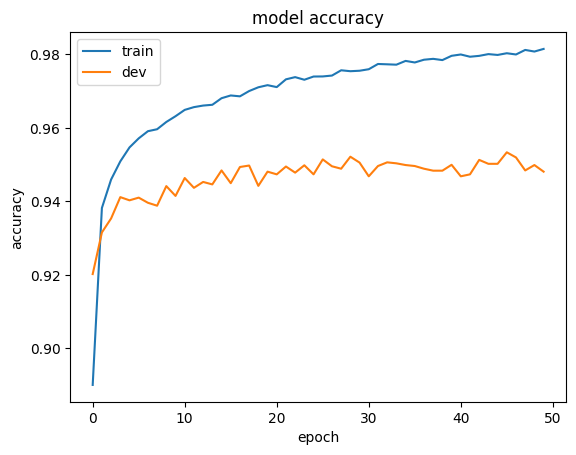

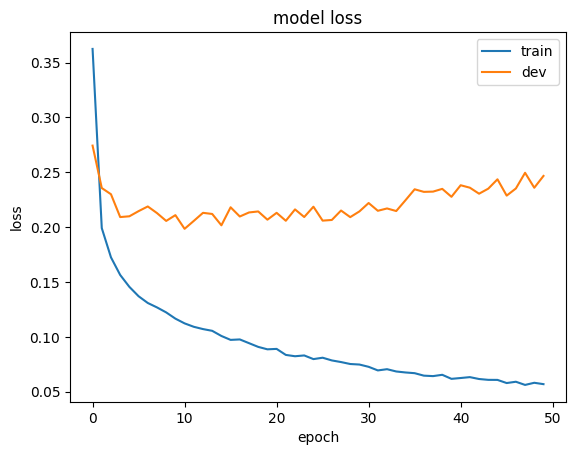

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

**Prediction and results**

We print classification reports and calculate AUC scores for different classes.

In [ ]:
from sklearn.metrics import roc_auc_score

y_train.reset_index(drop=True,inplace=True)
dict_match = {}

# Create a dictionary mapping original labels to one-hot encoded labels
for i in range(len(y_train)):
    dict_match[y_train[i]] = y_train_1_hot[i]

# Convert the one-hot encoded labels back to a single label for each class
modified_dict = {key: np.argmax(value,-1) for key, value in dict_match.items()}
y_dev_num = y_dev.replace(modified_dict)
y_dev_num.reset_index(drop=True,inplace=True)
labels = train_windows.Wi_POS_tag.unique()

def print_metrics(X, y, labels, set_name):

    if set_name != "Training Set":
        labels = labels[labels != 'SYM']

    # Replace categorical labels with numeric labels according to modified_dict
    y_num = y.replace(modified_dict)
    y_num.reset_index(drop=True,inplace=True)

    # Make predictions using the model for the given data
    predictions = np.argmax(model.predict(X), -1)
    print(f"-----------Predection Scores for {set_name}-----------")
    print("Classification Report")
    print(classification_report(y_num, predictions,
                                target_names=labels))
    print("AUC Scores for Classes")
    y_probs = model.predict(X_dev)
    n_classes = len(labels)
    macro_auc = 0

    # Calculate AUC for each class and accumulate to find macro AUC
    for i in range(n_classes):
        class_indices = (y_dev_num == i)
        if any(class_indices):
            class_auc = roc_auc_score((y_dev_num == i).astype(int), y_probs[:, i])
            print(f"AUC for class {labels[i]}: {class_auc}")
            macro_auc += class_auc
    macro_auc = macro_auc/n_classes
    print(f"Macro AUC: {macro_auc}")

print_metrics(X_train, y_train, labels, "Training Set")
print("\n\n")
print_metrics(X_dev, y_dev, labels, "Development Set")
print("\n\n")
print_metrics(X_test, y_test, labels, "Test Set")

2500/2500 [==============================] - 9s 4ms/step
-----------Predection Scores for Training Set-----------
Classification Report
              precision    recall  f1-score   support

         DET       0.99      0.98      0.98      7100
        NOUN       1.00      1.00      1.00      9675
         ADP       0.98      0.98      0.98      3988
       PROPN       0.98      1.00      0.99      3414
       PUNCT       0.99      0.98      0.98      2896
         ADJ       1.00      1.00      1.00      7966
         AUX       1.00      0.89      0.94         9
         ADV       0.99      1.00      0.99     19280
        VERB       0.99      0.98      0.98      1944
        PRON       0.92      0.99      0.95      2928
       CCONJ       1.00      1.00      1.00      3995
       SCONJ       1.00      1.00      1.00      8115
         NUM       0.95      0.77      0.85       844
           X       1.00      0.88      0.93         8
        INTJ       0.99      0.98      0.98      7708